In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost.callback import EarlyStopping

from scipy.stats import uniform, randint

# สำหรับการตั้งค่า seed เพื่อให้ผลลัพธ์ซ้ำเดิมได้ (Reproducibility)
import torch
from tensorflow import random as tf_random
from sklearn.utils import shuffle
from numpy.random import seed
tf_random.set_seed(1) # Use the function from the imported module
seed(1)

In [ ]:
def create_lag_features(df, feature_cols, n_lags):
    df_lagged = df.copy()

    for col in feature_cols:
        for lag in range(1, n_lags + 1):
            df_lagged[f'{col}_lag{lag}'] = df_lagged[col].shift(lag)

    return df_lagged

In [ ]:
path = "/content/train.csv"
data = pd.read_csv(path, parse_dates=['date'])
data

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
n_lags = 29

data = data.sort_values('date').groupby([ 'date', 'store','item'], as_index=False)
data = data.agg({'sales':['mean']})
data.columns = ['date', 'store','item', 'sales']
data['item'] = data['item'].astype('category')
data['store'] = data['store'].astype('category')
data['dayofweek'] = data['date'].dt.dayofweek
data['weekend'] = data['dayofweek'].isin([5, 6]).astype(int)
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['sale90'] = data.groupby(['store','item'])['sales'].shift(-90)
data = data.dropna()

data

<ipython-input-4-d54fe420c767>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['sale90'] = data.groupby(['store','item'])['sales'].shift(-90)


,date,store,item,sales,dayofweek,weekend,month,day,sale90
0,2013-01-01,1,1,13.0,1,0,1,1,11.0
1,2013-01-01,1,2,33.0,1,0,1,1,40.0
2,2013-01-01,1,3,15.0,1,0,1,1,23.0
3,2013-01-01,1,4,10.0,1,0,1,1,12.0
4,2013-01-01,1,5,11.0,1,0,1,1,14.0
...,...,...,...,...,...,...,...,...,...
867995,2017-10-02,10,46,51.0,0,0,10,2,70.0
867996,2017-10-02,10,47,18.0,0,0,10,2,22.0
867997,2017-10-02,10,48,48.0,0,0,10,2,60.0
867998,2017-10-02,10,49,32.0,0,0,10,2,42.0


In [ ]:
feature_cols = ['sales','store', 'item', 'dayofweek', 'weekend', 'month', 'day']
targets = 'sale90'

train = data[data['date'] < '2017-1-1']
test = data[data['date'] >= '2017-1-1']

train_set = create_lag_features(train, feature_cols=feature_cols, n_lags=n_lags)
test_set = create_lag_features(test, feature_cols=feature_cols, n_lags=n_lags)

train_set = train_set.dropna()
test_set = test_set.dropna()

X_train = train.drop(['sale90','date'], axis=1).values
y_train = train['sale90'].values
X_test = test.drop(['sale90','date'], axis=1).values
y_test = test['sale90'].values

<ipython-input-2-5d2578d87023>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{col}_lag{lag}'] = df_lagged[col].shift(lag)
<ipython-input-2-5d2578d87023>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{col}_lag{lag}'] = df_lagged[col].shift(lag)
<ipython-input-2-5d2578d87023>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

In [ ]:
param_dist = {
    'n_estimators': randint(300, 1500),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.05),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.3),
    'min_child_weight': randint(3, 10),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 1.5)
}

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='gpu_hist',
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42,
    error_score='raise'
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(0.2852142919229748), 'learning_rate': np.float64(0.046599697090570255), 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 421, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.5871254182522991), 'subsample': np.float64(0.9598528437324805)}


In [ ]:
print("Best Parameters:")
print("n_estimators", random_search.best_params_['n_estimators'])
print("max_depth", random_search.best_params_['max_depth'])
print("learning_rate", random_search.best_params_['learning_rate'])
print("subsample", random_search.best_params_['subsample'])
print("colsample_bytree", random_search.best_params_['colsample_bytree'])
print("gamma", random_search.best_params_['gamma'])
print("min_child_weight", random_search.best_params_['min_child_weight'])
print("reg_alpha", random_search.best_params_['reg_alpha'])
print("reg_lambda", random_search.best_params_['reg_lambda'])



Best Parameters:
n_estimators 421
max_depth 7
learning_rate 0.046599697090570255
subsample 0.9598528437324805
colsample_bytree 0.6872700594236812
gamma 0.2852142919229748
min_child_weight 7
reg_alpha 0.15599452033620265
reg_lambda 0.5871254182522991


In [ ]:
best_model = random_search.best_estimator_

In [ ]:
def evaluate(model, X, y, name="Test"):
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mse = mean_squared_error(y, preds)
    mae = mean_absolute_error(y, preds)
    mbe = np.mean(preds - y)
    r2 = r2_score(y, preds)
    mape = np.mean(np.abs((y - preds) / y)) * 100
    print(f"✅ MAPE  : {mape:.4f}")
    print(f"✅ MSE  : {mse:.4f}")
    print(f"✅ RMSE : {rmse:.4f}")
    print(f"✅ MBE  : {mbe:.4f}")
    print(f"✅ R²   : {r2:.4f}")
    return preds

print("\nTest Results:")
preds_test = evaluate(best_model, X_test, y_test, name="Test")



Test Results:
✅ MAPE  : 13.6577
✅ MSE  : 108.0774
✅ RMSE : 10.3960
✅ MBE  : -4.2639
✅ R²   : 0.8983


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


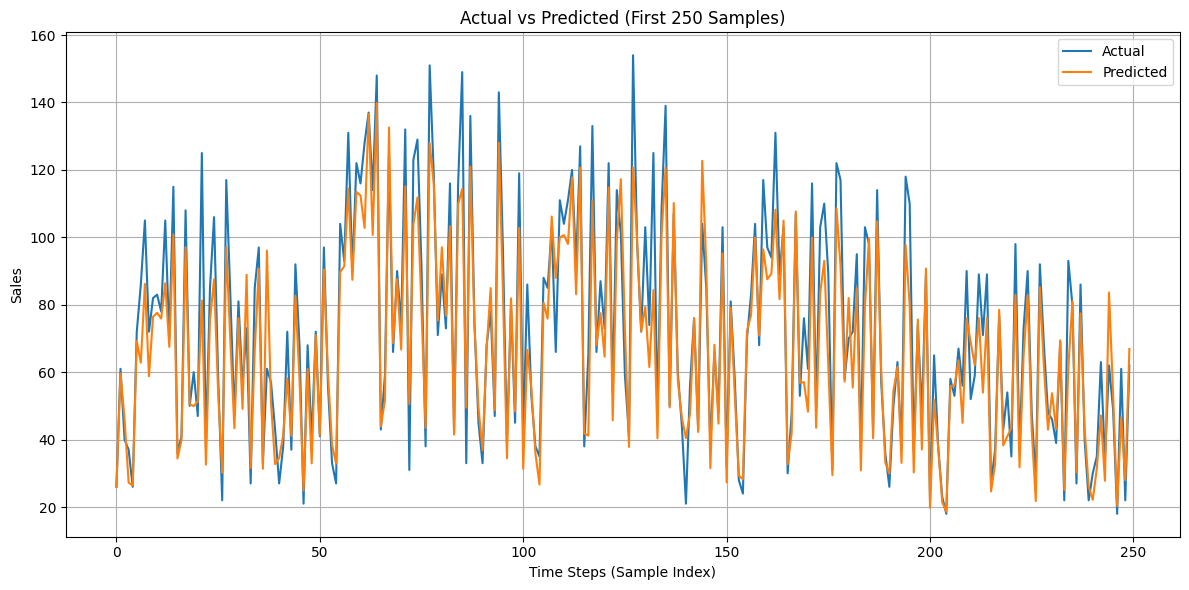

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:250], label='Actual')
plt.plot(preds_test[:250], label='Predicted')
plt.xlabel('Time Steps (Sample Index)')
plt.ylabel('Sales')
plt.title('Actual vs Predicted (First 250 Samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()